# 16. Parameter fitting

## Numerical experiments - Week 20/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using BlackBoxOptim
using JLD2
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./datautils.jl")
Revise.includet("./germstats.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .DataUtils
using .GermStats

## 1. Time-dependent Dantigny dataset generation

The estimated $P_{\textrm{max}}$, $\tau_g$ and $\nu$ parameters from Ijadpanahsaravi et al. [1] allow the reconstruction of time-dependent courses of the germination percentage. This is useful for providing more data points to fit the different inducer-inhibitor interaction models outlined in the previous notebook.

The data points for the arginine-rich medium are removed, since they have a broad variance and semi-saturation times longer than the documented time period.

In [2]:
t_max = 48
df_germination_rebuilt = parse_ijadpanahsaravi_data()
df_germination_rebuilt = filter(row -> row[1] != "Arg", df_germination_rebuilt) # Remove "Arg" from the dataset
dantigny_data, times, sources, densities, errs, p_maxs, taus, nus = generate_dantigny_dataset(df_germination_rebuilt, t_max)
size(dantigny_data)

(2, 4, 1000)

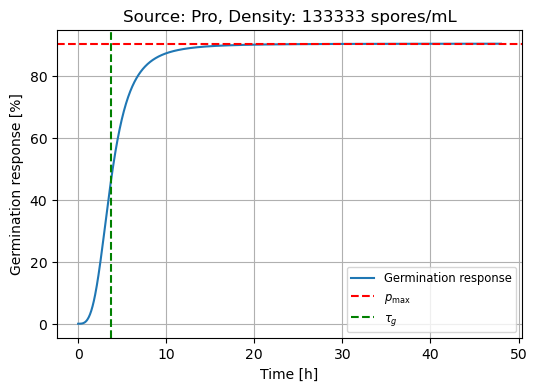

In [ ]:
src_idx = 2
density_idx = 3
# params_data = filter(row -> (row[:CarbonSource] == sources[src_idx]) && (row[:Density] == densities[density_idx]), df_germination_rebuilt)
plot_dantigny_time_course(p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                            germ_responses=dantigny_data[src_idx, density_idx, :], times=times,
                            title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")

## 2. Optimising the probability computation

The fitting procedure involves many executions of the probability calculation functions, which is computationally costly given the integral terms. Since the integration is over Gaussian probabilities, a Gauss-Hermite quadrature can be employed to compute the integrals much more efficiently. This requires the conversion of integration variables to standard Notmal variables first. In the case of $\xi$, one can define

$$
\begin{equation}
u=\frac{\xi-\mu_\xi}{\sigma_\xi} \implies \xi = \mu_\xi + \sigma_\xi u, \quad d{\xi}=\sigma_\xi d{u}.
\end{equation}
$$

If $\xi$ runs from $0$ to $+\infty$, then the interval of $u$ is from $u_0=\frac{-\mu_\xi}{\sigma_\xi}$ to $+\infty$. Hence, an integral like

$$
\begin{equation}
I=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}
\end{equation}
$$

becomes

$$
\begin{equation}
I=\int_{u_0}^\infty{\left[1-\Phi{\left(\frac{\beta{(\mu_\xi + \sigma_\xi u)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{u^2}{2}\right)}\ d{u}}.
\end{equation}
$$

Since the probability of $\xi$ being negative is negligible, the Gauss-Hermite approximation can be made:

$$
\begin{equation}
I=\int_{-\infty}^\infty{f{(u)}\ d{u}}\approx \int_{u_0}^\infty{f{(u)}\ d{u}}\approx \sum_{i=1}^{N}{w_if{(x)}},
\end{equation}
$$

where $w_i$ are precomputed weights. A weight count of $N=30$ is estimated to suffice for machine precision.

In the following sections, the probabilities are presented as untransformed integral, while the optimisation procedure manipulates them in the manner outlined above.

## 3. Fitting procedures for a static inducer

The following parameter estimations are based on the assumption of a constant level of the carbon source at the receptor proteins, i.e. in the case when the hydrophobin-melanin layer does not impose any temporal delay on the carbon signalling. The objective function minimizes both the difference between time-dependent germination measurements and between steady-state equilibrium probabilities, weighing the latter by the number of time points to preserve its relative importance.

### 3.1. Independent induction/inhibition

As determined previously, the germination probability in the first model follows the formula

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

In the equilibrium limit, this probability becomes

$$
\begin{equation}
p(\textrm{germination})=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

This model is expected to yield different outcomes depending on the inducing source, but the inhibitory effect is by definition independent from carbon signalling. Therefore, all parameters apart from $s$ are assumed to be constant over the different carbon sources.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-12, 1e-3),
    :s => (1e-12, 1.0),
    :μ_ω => (1e-12, 1.0),
    :σ_ω => (1e-12, 1.0)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("independent", def_params, dantigny_data, times, sources, densities, bounds, p_maxs * 0.01, max_steps=max_steps)

jldopen("Data/fit_independent.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: independent factors with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
74.60 secs, 2 evals, 1 steps, fitness=2378.627306845
93.24 secs, 4 evals, 2 steps, fitness=1976.575970854


In [ ]:
matplotlib.pyplot.close()

# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_independent.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

ss = params_opt[:s]
μ_ω = params_opt[:μ_ω]
σ_ω = params_opt[:σ_ω]
Pₛ = params_opt[:Pₛ]
μ_γ = params_opt[:μ_γ]
σ_γ = params_opt[:σ_γ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_combined_independent.(ss[sample_idx], μ_ω, σ_ω, Pₛ, density_range, μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_combined_independent(ss[src_idx], μ_ω, σ_ω, Pₛ, densities[density_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Independent inducer/inhibitor model, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

The model does not appear to reproduce the expected time course of the Dantigny model or an accurate representation of the dataset.

### 3.2. Inducer-dependent inhibition

In the second group of models, the germination depends on the depletion of the inhibitor and the inducer affects either the rate of release (as represented by the permeability), the threshold for inhibition, or both. The germination probability is expressed as

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

#### 3.2.1. Inducer shifts inhibition threshold

In the first case, it is assumed that the permeability remains constant over all inducing media, but it is the inhibition threshold that changes. Therefore, the $\gamma$ parameter is split into three cases, corresponding to the three carbon sources.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-12, 1e-3),
)

# bounds = Dict(
#     :Pₛ => (1e-4, 1e-3),
#     :μ_γ => (1e-20, 1e-4),
#     :σ_γ => (1e-20, 1e-4),
# )

max_steps = 1000
params_opt, rmse = fit_model_to_data("inhibitor_thresh", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Model: inducer-modulated inhibitor (threshold) with static inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.83 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=189.079978509
1.49 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=189.079978509
2.29 secs, 12 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=189.079978509
2.91 secs, 16 evals, 8 steps, improv/step: 0.750 (last = 0.0000), fitness=189.079978509
3.64 secs, 20 evals, 10 steps, improv/step: 0.700 (last = 0.5000), fitness=155.612007813
4.19 secs, 23 evals, 12 steps, improv/step: 0.750 (last = 1.0000), fitness=155.612007813
4.92 secs, 27 evals, 14 steps, improv/step: 0.714 (last = 0.5000), fitness=155.612007813
5.59 secs, 31 evals, 16 steps, improv/step: 0.688 (last = 0.5000), fitness=155.

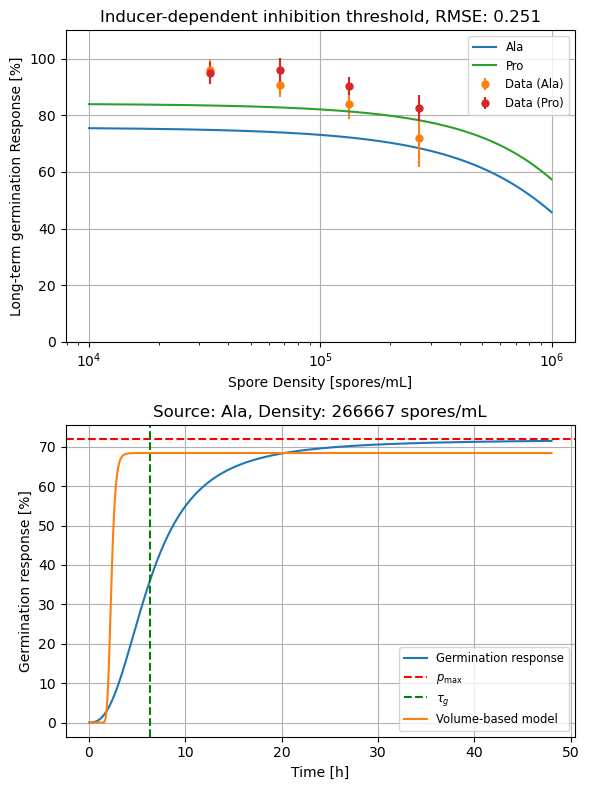

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inhibitor_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

Pₛ = params_opt[:Pₛ]
μ_γs = params_opt[:μ_γ]
σ_γs = params_opt[:σ_γ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_simple.(density_range, Pₛ, μ_γs[sample_idx], σ_γs[sample_idx], def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_simple(densities[density_idx], Pₛ, μ_γs[src_idx], σ_γs[src_idx], def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inducer-dependent inhibition threshold, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

#### 3.2.2. Inducer increases inhibitor permeation

In the second case, it is assumed that the inhibitor enhances the permeability of the inhibitor through the cell wall, accelerating its release. Hence, the threshold of inhibition remains the same, but $P_s$ varies across the carbon sources.

In [13]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-5, 1e-1),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-20, 1e-1)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inhibitor_perm", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor_perm.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Running inhibitor_perm model fitting with static inducer


UndefVarError: UndefVarError: `germination_response_simple` not defined

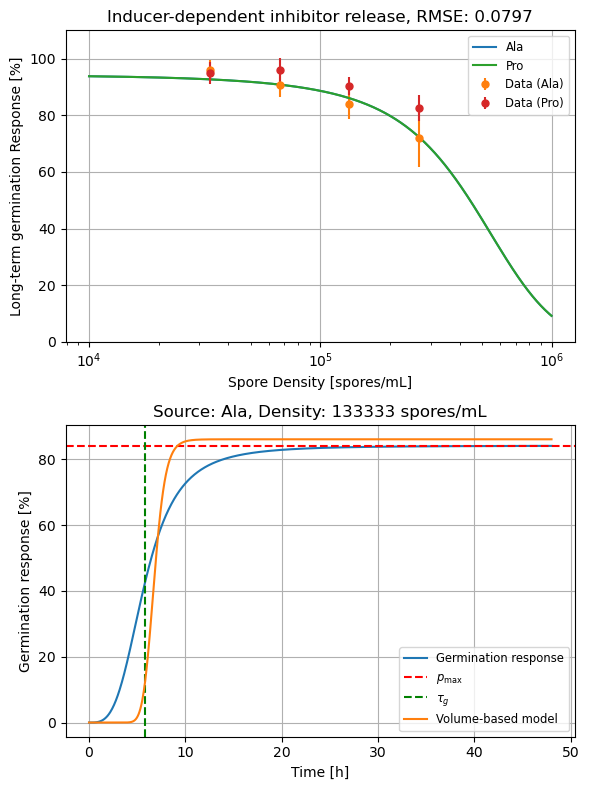

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inhibitor_perm.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

Pₛs = params_opt[:Pₛ]
μ_γ = params_opt[:μ_γ]
σ_γ = params_opt[:σ_γ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
# germ_resp_final = [germ_response_simple(densities[density_idx], Pₛs[src_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_density in density_range]
germ_resp_final = [germ_response_simple.(density_range, Pₛs[sample_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_simple(densities[density_idx], Pₛs[src_idx], μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inducer-dependent inhibitor release, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

#### 3.2.3. Inducer shifts inhibition threshold and increases inhibitor permeation

As a third option, the inducer is assumed to modulate both the inhibition threshold and the inhibitor permeation, making these parameters specific to each carbon source case.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :Pₛ => (1e-5, 1e-1),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-20, 1e-1)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inhibitor", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inhibitor.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.62 secs, 12 evals, 6 steps, improv/step: 0.333 (last = 0.3333), fitness=127.886445381
1.13 secs, 21 evals, 11 steps, improv/step: 0.455 (last = 0.6000), fitness=127.886445381
1.64 secs, 29 evals, 15 steps, improv/step: 0.533 (last = 0.7500), fitness=127.886445381
2.20 secs, 39 evals, 21 steps, improv/step: 0.429 (last = 0.1667), fitness=127.886445381
2.71 secs, 47 evals, 25 steps, improv/step: 0.440 (last = 0.5000), fitness=127.886445381
3.23 secs, 56 evals, 30 steps, improv/step: 0.467 (last = 0.6000), fitness=127.886445381
3.76 secs, 66 evals, 35 steps, improv/step: 0.514 (last = 0.8000), fitness=127.886445381
4.27 secs, 75 evals, 40 steps, improv/step: 0.500 (last = 0.4000), fitness=127.886445381
4.81 secs, 83 evals, 45 steps, improv/step: 0.444 (last = 0.0000), fitness=127.886445

Dict{Any, Any} with 3 entries:
  :σ_γ => Any[3.99988e-5, 3.88423e-5]
  :μ_γ => Any[5.05433e-5, 6.08059e-5]
  :Pₛ  => Any[0.000401665, 0.000536413]

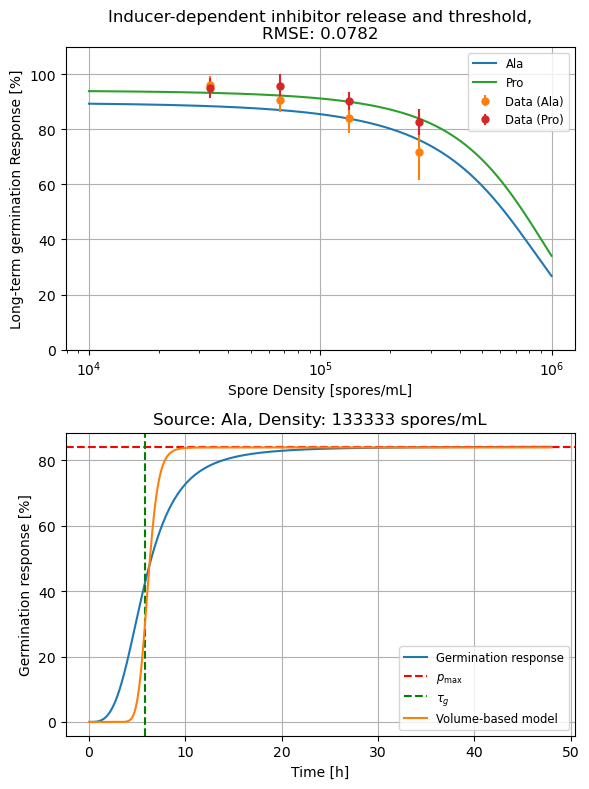

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inhibitor.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

Pₛs = params_opt[:Pₛ]
μ_γs = params_opt[:μ_γ]
σ_γs = params_opt[:σ_γ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_simple.(density_range, Pₛs[sample_idx], μ_γs[sample_idx], σ_γs[sample_idx], def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_simple(densities[density_idx], Pₛs[src_idx], μ_γs[src_idx], σ_γs[src_idx], def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inducer-dependent inhibitor release and threshold,\nRMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

### 3.3. Inhibitor-dependent carbon sensitivity

The third group of models examines the case in which the carbon source inducer triggers the germination programme, but its threshold or signalling strength are affected negatively by the presence of the inhibitor.

#### 3.3.1. Inhibitor shifts inducer threshold

In the first case, the residial concentration of inhibitor in the spore is assumed to shift the activation threshold for the carbon signalling. The germination probability is defined as follows:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}},
\end{equation}
$$

with

$$
\begin{equation}
f_\psi{(\psi)} = \frac{1}{\sqrt{2\pi}\sigma_\psi}e^{-\frac{(\psi-\mu_\psi)^2}{2\sigma_\psi^2}},
\end{equation}
$$

$$
\begin{equation}
f_\xi{(\xi)} = \frac{1}{\sqrt{2\pi}\sigma_\xi}e^{-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}}.
\end{equation}
$$

The signal strength $s$ and the succeptibility toward inhibition $k$ are source-specific, while $\mu_{\omega_0}$ and $\sigma_{\omega_0}$ and the other free parameters remain constant over the medium compositions.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :s => (1e-12, 100.0),
    :k => (1e-12, 100.0),
    :μ_ω => (1e-12, 100.0),
    :σ_ω => (1e-12, 100.0),
    :Pₛ => (1e-5, 1e-1),
    :μ_ψ => (1e-10, 1.0),	
    :σ_ψ => (1e-20, 0.1)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inducer_thresh", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inducer_thresh.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
2.51 secs, 2 evals, 1 steps, fitness=659.514671379
4.92 secs, 4 evals, 2 steps, fitness=659.514671379
7.30 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 1.0000), fitness=659.514671379
9.45 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 1.0000), fitness=659.514671379
11.69 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 1.0000), fitness=659.514671379
13.61 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 0.0000), fitness=644.998680794
15.46 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 0.0000), fitness=644.998680794
17.38 secs, 16 evals, 8 steps, improv/step: 0.500 (last = 1.0000), fitness=644.998680794
19.19 secs, 18 evals, 9 steps, improv/step: 0.556 (last = 1.0000), fitness=573.955589633
20.12 secs, 19 evals, 10 steps, improv/step: 0.600 (last = 1.0000), fitness

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inducer_thresh.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

ss = params_opt[:s]
ks = params_opt[:k]
μ_ω = params_opt[:μ_ω]
σ_ω = params_opt[:σ_ω]
Pₛ = params_opt[:Pₛ]
μ_ψ = params_opt[:μ_ψ]
σ_ψ = params_opt[:σ_ψ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_inhibitor_dependent_inducer_thresh.(ss[sample_idx], ks[sample_idx], μ_ω, σ_ω, density_range, Pₛ, μ_ψ, σ_ψ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_inhibitor_dependent_inducer_thresh.(ss[src_idx], ks[src_idx], μ_ω, σ_ω, densities[density_idx], Pₛ, μ_ψ, σ_ψ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inhibitor-dependent inducer threshold, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

#### 3.3.2. Inhibitor attenuates inducing signal

In the second scenario, the inhibitor is assumed to interfere with the signal strength by classic inhibitor kinetics. The probability for germination is

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_\omega}{\sigma_\omega}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

Once again, $s$ is specific for the molecular species. As it is not known if the inhibitor interacts directly with the carbon molecules, with the receptor proteins or with elements further down the signalling pathway, it can be assumed that $K_I$ and $n$ also vary depending on the carbon source type. All other parameters reimain general to the system.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :s => (1e-12, 100.0),
    :K => (1e-10, 10.0),
    :n => (1.0, 3.0),
    :μ_ω => (1e-12, 100.0),
    :σ_ω => (1e-12, 100.0),
    :Pₛ => (1e-5, 1e-1),
    :μ_ψ => (1e-10, 1.0),	
    :σ_ψ => (1e-20, 0.1)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inducer_signal", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inducer_signal.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inducer_signal.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

ss = params_opt[:s]
Ks = params_opt[:K]
ns = params_opt[:n]
μ_ω = params_opt[:μ_ω]
σ_ω = params_opt[:σ_ω]
Pₛ = params_opt[:Pₛ]
μ_ψ = params_opt[:μ_ψ]
σ_ψ = params_opt[:σ_ψ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_inhibitor_dependent_inducer_signal.(ss[sample_idx], Ks[sample_idx], ns[sample_idx], μ_ω, σ_ω, density_range, Pₛ, μ_ψ, σ_ψ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_inhibitor_dependent_inducer_signal.(ss[src_idx], Ks[src_idx], ns[src_idx], μ_ω, σ_ω, densities[density_idx], Pₛ, μ_ψ, σ_ψ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inhibitor-dependent inducer signal, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

#### 3.3.3. Inhibitor shifts inducer threshold and attenuates inducing signal

Finally, in the combined scenario, the probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

This is the model with the most unknown parameters (13), with $s$, $k$, $K_I$ and $n$ varying per inducer and the rest remaining constant for each sub-dataset.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
)

bounds = Dict(
    :s => (1e-12, 100.0),
    :k => (1e-12, 100.0),
    :K => (1e-10, 10.0),
    :n => (1.0, 3.0),
    :μ_ω => (1e-12, 100.0),
    :σ_ω => (1e-12, 100.0),
    :Pₛ => (1e-5, 1e-1),
    :μ_ψ => (1e-10, 1.0),	
    :σ_ψ => (1e-20, 0.1)
)

max_steps = 1000
params_opt, rmse = fit_model_to_data("inducer", def_params, dantigny_data, times, sources, densities, bounds, p_maxs*0.01, max_steps=max_steps)

jldopen("Data/fit_inducer.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_inducer.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

ss = params_opt[:s]
ks = params_opt[:k]
Ks = params_opt[:K]
ns = params_opt[:n]
μ_ω = params_opt[:μ_ω]
σ_ω = params_opt[:σ_ω]
Pₛ = params_opt[:Pₛ]
μ_ψ = params_opt[:μ_ψ]
σ_ψ = params_opt[:σ_ψ]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_inhibitor_dependent_inducer_combined.(ss[sample_idx], ks[sample_idx], Ks[sample_idx], ns[sample_idx], μ_ω, σ_ω, density_range, Pₛ, μ_ψ, σ_ψ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_inhibitor_dependent_inducer_combined.(ss[src_idx], ks[src_idx], Ks[src_idx], ns[src_idx], μ_ω, σ_ω, densities[density_idx], Pₛ, μ_ψ, σ_ψ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inhibitor-dependent inducer signal and threshold, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

## 4. Fitting procedures for a time-dependent inducer

Introducing a time-dependent increase of the inducer concentration by the formula

$$
\begin{equation}
c_{\textrm{cs}}{(t)}=c_{\textrm{cs}}^{\textrm{out}}(1-e^{-t/\tau_{\textrm{cs}}}),
\end{equation}
$$

in which the characteristic permeation time is defined as

$$
\begin{equation}
\tau_{\textrm{cs}}=\frac{V_{\textrm{cw}}}{P_s^{\textrm{cs}}A_s},\quad V_{\textrm{cw}}=0.24\,\frac{4}{3}\pi[(\xi-d_{\textrm{hp}})^3-(\xi-d_{\textrm{hp}}-\kappa)^3]
\end{equation}
$$

which increases the signalling strength via Michaelis-Menten kinetics:

$$
\begin{equation}
s{(c_{\textrm{cs}})}=s_{\textrm{max}}\ \frac{c_{\textrm{cs}}}{K_{\textrm{cs}}+c_{\textrm{cs}}},
\end{equation}
$$

introduces two new unknown parameters: $P_s^{\textrm{cs}}$ and $K_{\textrm{cs}}$, and replaces the parameter $s$ by a saturation limit $s_{\textrm{max}}$. All of these new parameters are medium-specific.

### 4.1. Independent induction/inhibition (time-dependent inducer)

As the signal is now dependent on the fluctuating spore radius and polysaccharide layer thickness, the germination probability changes to

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-\mu_\omega}{\sigma_\omega}\right)}\left[1-\Phi{\left(\frac{\beta{(\xi, t)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

While data is lacking on the conidial cell wall thickness, a reasonable guess yields an average of $200\ \textrm{nm}$ and a standard deviation of $50\ \textrm{nm}$.

In [43]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
    :c₀_cs => 0.01,
    :d_hp => 0.01,
    :μ_κ => 0.2,
    :σ_κ => 0.05
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-12, 1e-1),
    :s_max => (1e-12, 100.0),
    :μ_ω => (1e-12, 100.0),
    :σ_ω => (1e-12, 100.0),
    :K_cs => (1e-10, 1000.0),
    :Pₛ_cs => (1e-6, 1e-1)
)

max_steps = 10#00
params_opt, rmse = fit_model_to_data("independent", def_params, dantigny_data, times, sources, densities, bounds, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/fit_independent_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

Running independent model fitting with time-dependent inducer
Running first optimisation stage
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
3.37 secs, 2 evals, 1 steps, fitness=5296.496253199
5.95 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=1586.929546078
8.55 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=1024.180859605
10.82 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 0.5000), fitness=1024.180859605
12.92 secs, 12 evals, 6 steps, improv/step: 0.333 (last = 0.0000), fitness=1024.180859605
15.23 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 1.0000), fitness=1024.180859605
17.43 secs, 18 evals, 9 steps, improv/step: 0.556 (last = 1.0000), fitness=1024.180859605
19.83 secs, 20 evals, 10 steps, improv/step: 0.500 (last = 0.0000), fitness=1024.180859605

Optimization stopped 

Dict{Any, Any} with 8 entries:
  :σ_γ   => Any[0.0134216]
  :K_cs  => Any[35.8229, 582.209]
  :μ_ω   => Any[1.0e-12]
  :μ_γ   => Any[0.051469]
  :s_max => Any[99.727, 61.8621]
  :σ_ω   => Any[99.9882]
  :Pₛ_cs => Any[0.0440962, 0.0657737]
  :Pₛ    => Any[0.000204851]

2
(1000,)


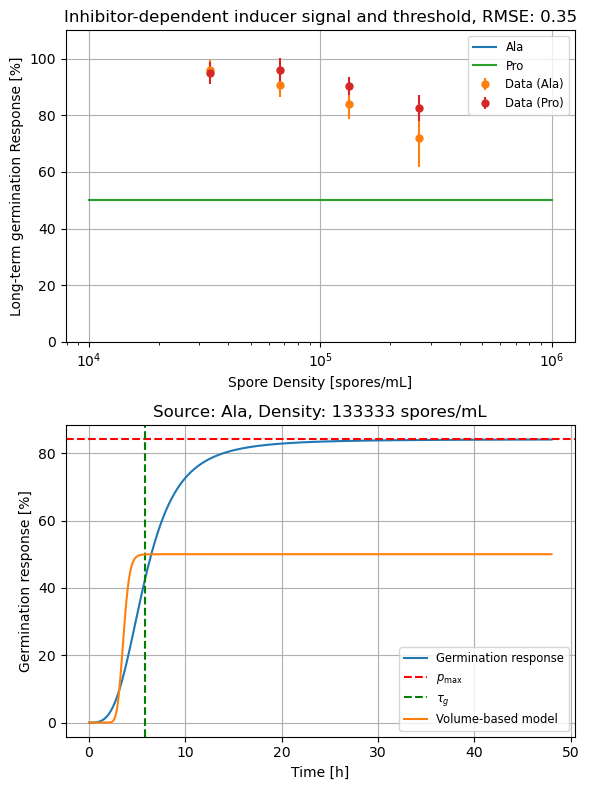

In [ ]:
# Load the fitted parameters
t_max, def_params, bounds, params_opt, max_steps, rmse = jldopen("Data/fit_independent_st.jld2", "r") do file
    return file["t_max"], file["def_params"], file["bounds"], file["params_opt"], file["max_steps"], file["rmse"]
end

s_maxs = params_opt[:s_max]
K_css = params_opt[:K_cs]
μ_ω = params_opt[:μ_ω]
σ_ω = params_opt[:σ_ω]
Pₛ = params_opt[:Pₛ]
μ_γ = params_opt[:μ_γ]
σ_γ = params_opt[:σ_γ]
Pₛ_css = params_opt[:Pₛ_cs]

src_idx = 2
density_idx = 4

# Compute germination responses using the fitted parameters
density_exp_range = LinRange(4, 6, 1000)
density_range = 10 .^ density_exp_range
germ_resp_final = [germ_response_combined_independent_st.(s_maxs[sample_idx], K_css[sample_idx], def_params[:c₀_cs], Pₛ_css[sample_idx], def_params[:μ_κ], def_params[:σ_κ], def_params[:d_hp], μ_ω, σ_ω,
                                                            density_range, Pₛ, μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], t_max*3600) for sample_idx in 1:length(sources)]
germ_resp_sample = germ_response_combined_independent_st.(s_maxs[src_idx], K_css[src_idx], def_params[:c₀_cs], Pₛ_css[src_idx], def_params[:μ_κ], def_params[:σ_κ], def_params[:d_hp], μ_ω, σ_ω,
                                                            densities[density_idx], Pₛ, μ_γ, σ_γ, def_params[:μ_ξ], def_params[:σ_ξ], times)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs = axs[:]
plot_germination_data_fit(densities, p_maxs, density_range, germ_resp_final .* 100, sources, yerr=errs, ax=axs[1], title="Inhibitor-dependent inducer signal and threshold, RMSE: $(round(rmse, sigdigits=3))")
compare_time_course_to_dantigny(germ_resp_sample, times, p_maxs[src_idx, density_idx], taus[src_idx, density_idx], nus[src_idx, density_idx],
                                ax=axs[2], title="Source: $(sources[src_idx]), Density: $(round(Int,densities[density_idx])) spores/mL")
                            

tight_layout()
gcf()

### 4.2. Inducer-dependent inhibition (time-dependent inducer)

Under a time-dependent inducer signal, the three cases of inducer-dependent inhibition become as follows.

#### 4.2.1. Inducer shifts inhibition threshold

As the inducing signal now evolves over time, it cannot be absorbed into $\gamma$ and must therefore be explicitly included in the relationship $\gamma = \gamma_0 + s$. There is still an inherent variation in $\gamma_0$ and a proportionality factor between $s$ and the modulation strength can be omitted, since the scale of $s_{\textrm{max}}$ is arbitrary. Therefore, the condition for germination becomes

$$
\begin{equation}
\beta < \gamma_0 + s \quad \Longrightarrow \quad \beta - s < \gamma_0
\end{equation}
$$

and the probability is

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}})}-s{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}}.
\end{equation}
$$

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
    :c₀_cs => 0.01,
    :d_hp => 0.01
    :μ_κ => 0.2,
    :σ_κ => 0.05
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-12, 1e-1),
    :s_max => (1e-12, 100.0),
    :K_cs => (1e-10, 1000.0),
    :Pₛ_cs => (1e-6, 1e-2),
)

max_steps = 10#00
params_opt, rmse = fit_model_to_data("inhibitor_thresh", def_params, dantigny_data, times, sources, densities, bounds, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/inhibitor_thresh_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

#### 4.2.2. Inducer increases inhibitor permeation

There is insufficient data to define a plausible mechanism for the modulation of the inhibitor release by the inducing signal, so simple model can be adopted in which $P_{\textrm{eff}}=sP_{\textrm{eff}}^{\textrm{max}}$, i.e. the permeation constant is increased from zero to a maximum limit depending on the inducing signal. Since $s$ is a saturating quantity (due to its Michaelis-Menten kinetics), so would the modified permeability be. Hence, the probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{eff}}^{\textrm{max}}, s)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}},
\end{equation}
$$

where

$$
\begin{equation}
\beta = \phi+(1-\phi)e^{-s{(\xi,\kappa,t)}P_{\textrm{eff}}^{\textrm{max}}\frac{A_s}{V_s(1-\phi)}t}.
\end{equation}
$$

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
    :c₀_cs => 0.01,
    :d_hp => 0.01
    :μ_κ => 0.2,
    :σ_κ => 0.05
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-6, 1e-1),
    :σ_γ => (1e-12, 1e-1),
    :s_max => (1e-12, 100.0),
    :K_cs => (1e-10, 1000.0),
    :Pₛ_cs => (1e-6, 1e-2),
)

max_steps = 10#00
params_opt, rmse = fit_model_to_data("inhibitor_perm", def_params, dantigny_data, times, sources, densities, bounds, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/inhibitor_perm_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

#### 4.2.3. Inducer shifts inhibition and increases inhibitor permeation

When considering the combined effects of the inducer on the inhibitor, the probability becomes

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_{\textrm{max}}, s)}-ks{(\xi, \kappa, t)}-\mu_{\gamma_0}}{\sigma_{\gamma_0}}\right)}\right]\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ d{\kappa}}\ d{\xi}},
\end{equation}
$$

whereby one differentiates the effect on the threshold from the effect on the permeability by the proportionality constant $k$.

In [ ]:
def_params = Dict(
    :μ_ξ => 2.65,
    :σ_ξ => 0.3,
    :c₀_cs => 0.01,
    :d_hp => 0.01
    :μ_κ => 0.2,
    :σ_κ => 0.05
)

bounds = Dict(
    :Pₛ => (1e-4, 1e-3),
    :μ_γ => (1e-5, 1e-1),
    :σ_γ => (1e-5, 1e-1),
    :s_max => (1e-12, 100.0),
    :k => (1e-4, 1e4),
    :K_cs => (1e-10, 1000.0),
    :Pₛ_cs => (1e-6, 1e-2),
)

max_steps = 10#00
params_opt, rmse = fit_model_to_data("inhibitor", def_params, dantigny_data, times, sources, densities, bounds, p_maxs * 0.01, st=true, max_steps=max_steps)

jldopen("Data/inhibitor_st.jld2", "w") do file
    file["t_max"] = t_max
    file["def_params"] = def_params
    file["bounds"] = bounds
    file["params_opt"] = params_opt
    file["max_steps"] = max_steps
    file["rmse"] = rmse
end

params_opt

### 4.3. Inhibitor-dependent carbon sensitivity (time-dependent inducer)

The time-dependence of the inducer permeation also bears consequences for the inhibitor-dependent carbon signalling, adding a second modification of the signalling pathway leading to germination.

#### 4.3.1. Inhibitor shifts inducer threshold

In the first scenario, the main change in the germination probability is the replacement of $s$ by its time-dependent counterpart and the integration over the inner cell wall thicknesses:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}-kc_{\textrm{in}}{(\xi, \psi)}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\kappa{(\kappa)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\kappa}}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

#### 4.3.2. Inhibitor attentuates inducer signal

The same modification applies to the second scenario:

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_\omega}{\sigma_\omega}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

#### 4.3.3. Inhibitor shifts inducer threshold and attenuates inducing signal

The combined case has the probability

$$
\begin{equation}
p(\textrm{germination})=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s{(\xi, \kappa, t)}\left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-kc_{\textrm{in}}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ f_\xi{(\xi)}\ f_\psi{(\psi)}\ d{\xi}}\ d{\psi}}.
\end{equation}
$$

In [10]:
using FastGaussQuadrature

ghnodes, ghweights = gausshermite(100)

t_eval = 12*3600

# Inhibitor (constant inducer)
println(germ_response_simple(1e5, 1e-4, 2e-5, 1e-5, 2.5, 0.3, t_eval))
println(germ_response_inhibitor_gh(t_eval, inverse_mL_to_cubic_um(1e5), 2.5, 0.3, 1e-4, 2e-5, 1e-5, ghnodes, ghweights))

# Independent (constant inducer)
println("")
println(germ_response_combined_independent(0.5, 0.7, 0.1, 1e5, 1e-4, 2e-5, 1e-5, 2.5, 0.3, t_eval))
println(germ_response_independent_factors_gh(t_eval, inverse_mL_to_cubic_um(1e5), 2.5, 0.3, 1e-4, 0.5, 2e-5, 1e-5, 0.7, 0.1, ghnodes, ghweights))

# Independent (time-dependent inducer)
println("")
println(germ_response_combined_independent_st(0.5, 0.7, 0.01, 1e3, 0.2, 0.01, 0.01, 0.7, 0.1, 1e5, 1e-4, 2e3, 1e3, 2.5, 0.3, t_eval))
println(germ_response_independent_factors_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.3, 0.2, 0.01, 1e-4, 1e3, 0.5, 0.7, 2e3, 1e3, 0.7, 0.1, ghnodes, ghweights))

# Inhibitor-threshold (time-dependent inducer)
println("")
println(germ_response_inducer_dependent_inhibitor_thresh_st(0.6, 0.05, 0.01, 1e-5, 0.2, 0.05, 0.01, 1e5, 1e-4, 2e-5, 1e-5, 2.5, 0.3, t_eval))
println(germ_response_inducer_dep_inhibitor_thresh_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.3, 0.2, 0.05, 1e-4, 1e-5, 0.6, 0.05, 2e-5, 1e-5, ghnodes, ghweights))

# Inhibitor-perm (time-dependent inducer)
println("")
println(germ_response_inducer_dependent_inhibitor_perm_st(100, 0.02, 0.01, 1e-6, 0.2, 0.05, 0.01, 1e5, 1e-5, 2e-5, 1e-5, 2.5, 0.3, t_eval))
println(germ_response_inducer_dep_inhibitor_perm_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.3, 0.2, 0.05, 1e-5, 1e-6, 100, 0.02, 2e-5, 1e-5, ghnodes, ghweights))

# Inhibitor-perm and threshold (time-dependent inducer)
println("")
println(germ_response_inducer_dependent_inhibitor_combined_st(2, 20, 0.02, 0.01, 1e-6, 0.2, 0.05, 0.01, 1e5, 1e-4, 2e-5, 1e-5, 2.5, 0.3, t_eval))
println(germ_response_inducer_dep_inhibitor_combined_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.3, 0.2, 0.05, 1e-4, 1e-6, 2, 0.02, 20, 2e-5, 1e-5, ghnodes, ghweights))

# Inducer-threshold (constant inducer)
println("")
println(germ_response_inhibitor_dependent_inducer_thresh(10, 2, 11, 2, 1e5, 1e-5, 1e-5, 1e-6, 2.5, 0.3, t_eval))
println(germ_response_inhibitor_dep_inducer_thresh_gh(t_eval, inverse_mL_to_cubic_um(1e5), 2.5, 0.3, 1e-5, 10, 2, 11, 2, 1e-5, 1e-6, ghnodes, ghweights))

# Inducer-threshold (time-dependent inducer)
println("")
println(germ_response_inhibitor_dep_inducer_thresh_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.5, 0.2, 0.05, 1e-4, 1e-5, 10, 0.02, 2, 11, 2, 1e-5, 1e-6, ghnodes, ghweights))

# Inducer-signal (constant inducer)
println("")
println(germ_response_inhibitor_dependent_inducer_signal(10, 1e2, 2, 11, 3, 1e5, 1e-4, 1e-5, 1e-6, 2.5, 0.3, t_eval))
println(germ_response_inhibitor_dep_inducer_signal_gh(t_eval, inverse_mL_to_cubic_um(1e5), 2.5, 0.3, 1e-4, 10, 1e2, 2, 11, 3, 1e-5, 1e-6, ghnodes, ghweights))

# Inducer-signal (time-dependent inducer)
println("")
println(germ_response_inhibitor_dep_inducer_signal_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.3, 0.2, 0.05, 1e-4, 1e-5, 10, 0.02, 1e-3, 2, 11, 3, 1e-5, 1e-6, ghnodes, ghweights))

# Inhibitor-signal and threshold (constant inducer)
println("")
println(germ_response_inhibitor_dependent_inducer_combined(10, 2, 1e-3, 2, 11, 3, 1e5, 1e-4, 1e-5, 1e-6, 2.5, 0.3, t_eval))
println(germ_response_inhibitor_dep_inducer_combined_gh(t_eval, inverse_mL_to_cubic_um(1e5), 2.5, 0.3, 1e-4, 10, 2, 1e-3, 2, 11, 3, 1e-5, 1e-6, ghnodes, ghweights))

# Inhibitor-signal and threshold (time-dependent inducer)
println("")
println(germ_response_inhibitor_dep_inducer_combined_st_gh(t_eval, inverse_mL_to_cubic_um(1e5), 0.01, 0.01, 2.5, 0.3, 0.2, 0.05, 1e-4, 1e5, 10, 1, 1e-3, 1e-3, 2, 11, 3, 1e-5, 1e-6, ghnodes, ghweights))

1.9317456069979533e-9
1.932572217800909e-9

4.957415500643539e-11
4.957415500643542e-11

2.062445567360378e-12
2.062482408933831e-12

0.9998883648446925
0.9999999999919784

0.661213738937182
0.6612762614819768

0.9998883648446925
1.0

0.30853486175984346
0.308535453750275

6.31547020354709e-5

0.3694406313303602
0.36944134018176367

0.005298734218639543

0.3694406086569447
0.3694413175077461

0.26226970599128774


In [127]:
using MeshGrid
a = 1:3
b = 1:3
c = 1:3
size(meshgrid(a, b, c)[1])

(3, 3, 3)

In [13]:
using FastGaussQuadrature, Distributions

"""
    gauss_hermite_integral(N; μξ, σξ, μγ, σγ, ϕ, τ)

Approximate I = ∫₀^∞ [1 - Φ((β(ξ) - μγ)/σγ)] · N(ξ;μξ,σξ²) dξ
by Gauss–Hermite with N nodes.  Here
  β(ξ) = ϕ + (1-ϕ) * exp(-ξ / (τ*(1-ϕ))),
and Φ is the CDF of N(μγ,σγ²).  
"""
function gauss_hermite_integral(N;
    μξ::Float64, σξ::Float64,
    μγ::Float64, σγ::Float64,
    ϕ::Float64, τ::Float64,
)
    # 1) get GH nodes & weights for ∫_{-∞}^∞ g(x) e^{-x²} dx
    x, w = gausshermite(N)

    # 2) transform to standard Normal ∫ g(u) φ(u) du
    #    u = √2·x,   du = √2 dx,   e^{-x²} dx = e^{-u²/2} dx = e^{-u²/2} (du/√2)
    #    so φ(u) = (1/√(2π)) e^{-u²/2}  ⇒  weights = w / √π
    u = √2 .* x
    hw = w ./ √π

    # 3) define the integrand at each u_i
    #    ξ = μξ + σξ * u
    ξ = μξ .+ σξ .* u
    β = ϕ .+ (1 .- ϕ) .* exp.(-ξ ./ (τ*(1-ϕ)))

    # 4) compute 1 - Φ((β-μγ)/σγ)
    dist = Normal(μγ, σγ)
    tail = 1 .- cdf.(dist, β)

    # 5) weighted sum
    return sum(hw .* tail)
end

# Example usage:
N = 30                   # number of GH nodes
μξ, σξ = 5.0, 2.0
μγ, σγ = 0.0, 1.0
ϕ, τ   = 0.2, 3.0

Î = gauss_hermite_integral(N;
       μξ=μξ, σξ=σξ, μγ=μγ, σγ=σγ, ϕ=ϕ, τ=τ)
println("Approximate I = ", Î)


Approximate I = 0.36819358075111647


## References

- [1] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .